# Specviz Simple Demo

**Use case:** This notebook demonstrates how to inspect spectra in Specviz, export spectra from the GUI in the notebook, select regions in the GUI and in the notebook, and measure the redshift of a source in the GUI.<br>
**Data:** NIRISS 1D spectra from the [NGDEEP survey](https://ui.adsabs.harvard.edu/abs/2023arXiv230205466B/abstract). The dataset has been processed with the default pipeline and is read from AWS.<br>
**Tools:** specutils, jdaviz, astropy, numpy.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

**Updated on**: 2025/10/20 by Bryan Hilbert

## Table of Contents

1. [Load NIRISS pipeline output](#1.-Load-NIRISS-pipeline-output)
2. [Open Specviz and load the 1D spectra we are interested in](#2.-Open-Specviz-and-load-the-1D-spectra-we-are-interested-in)
3. [Select the emission lines using the GUI and in the notebook](#3.-Select-the-emission-lines-using-the-GUI-and-in-the-notebook)
4. [Use the redshift slider in Specviz to find the redshift](#4.-Use-the-redshift-slider-in-Specviz-to-find-the-redshift)
5. [Model the continuum of the spectrum](#5.-Model-the-continuum-of-the-spectrum)

Imports:
- matplotlib for plotting data
- astropy for handling of fits files, units, and tables
- specutils for interactions with Specviz and region definition/extraction
- jdaviz for the visualization tool Specviz
- astroquery to get the data from AWS
- numpy to help select the appropriate source from the data file

In [1]:
# Plotting and tabling
import matplotlib.pyplot as plt

# Import astropy and numpy
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astropy.nddata import StdDevUncertainty
import numpy as np

# Import specutils
import specutils
from specutils import Spectrum, SpectralRegion
from specutils.manipulation import extract_region

# Import viztools
import jdaviz
from jdaviz import Specviz

# Astroquery
from astroquery.mast import Observations

In [2]:
# Customization of matplotlib style
plt.rcParams["figure.figsize"] = (10, 5)
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
          'axes.titlesize': '18', 'xtick.labelsize': '18',
          'ytick.labelsize': '18', 'lines.linewidth': 2,
          'axes.linewidth': 2, 'animation.html': 'html5',
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

Check versions

In [3]:
print('astropy:', astropy.__version__)
print('specutils:', specutils.__version__)
print('jdaviz:', jdaviz.__version__)

astropy: 7.1.1
specutils: 2.2.0
jdaviz: 4.4.1


## 1. Load NIRISS pipeline output
We get the data directly from AWS by searching for proposal 2079 and NIRISS instrument in WFSS mode. The filename we are looking for is jw02079-o001_t001_niriss_f150w-gr150c_x1d.fits. Uncomment the line with `download_products` if you want to save a local copy of the file.

In [4]:
# Simply call the `enable_cloud_dataset` method from `Observations`.
# The default provider is `AWS`, but we will write it in manually for this example:
Observations.enable_cloud_dataset(provider='AWS')

# Getting the cloud URIs
obs_table = Observations.query_criteria(proposal_id=['2079'],
                                        instrument_name=['NIRISS/WFSS'],
                                        dataproduct_type=['spectrum'])
products = Observations.get_product_list(obs_table)
filtered = Observations.filter_products(products, productFilename=['jw02079-o001_t001_niriss_f150w-gr150c_x1d.fits'])
s3_uris = Observations.get_cloud_uris(filtered)
print(s3_uris)

# Download the data locally if you want
# Observations.download_products(filtered, cloud_only=True)
# will save to ./mastDownload/JWST/jw02079-o001_t001_niriss_f150w-gr150c/jw02079-o001_t001_niriss_f150w-gr150c_x1d.fits

Observations.disable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


['s3://stpubdata/jwst/public/jw02079/L3/t/o001/jw02079-o001_t001_niriss_f150w-gr150c_x1d.fits']


In [5]:
# Choose a source that we know has some obvious emission lines. We choose the
# source based on its location rather than source_id, since the source_id can
# vary when source finding parameters are changed.
source_x, source_y = (1803.749, 986.392)

In [6]:
# Open file in read-only mode and get the data
with fits.open(s3_uris[0], 'readonly', fsspec_kwargs={"anon": True}) as hdu:
    # Each extension after the 0th contains information about all sources in the file.
    # Each extension corresponds to the information recovered from one input exposure.
    # For this example, we will focus on the data only in the 1st extension.
    hdu.info()

    # Locate the index number corresponding to our source of interest. Search the reported
    # (x,y) positions for all sources and find the source that is closest to our chosen source.
    delta_x = source_x - hdu[1].data["SOURCE_XPOS"]
    delta_y = source_y - hdu[1].data["SOURCE_YPOS"]
    delta_loc = np.sqrt(delta_x**2 + delta_y**2)
    idx = np.where(delta_loc == np.nanmin(delta_loc))[0][0]

    print(f'Using source_id: {hdu[1].data["SOURCE_ID"][idx]} at index: {idx}')
    print(f'Source is located at (x,y) = ({hdu[1].data["SOURCE_XPOS"][idx]}, {hdu[1].data["SOURCE_YPOS"][idx]})')
    
    # Create Spectrum object (will not be needed when Jdaviz can open file directly from S3)
    wave = hdu[1].data['WAVELENGTH'][idx, :] * u.Unit(hdu[1].header['TUNIT2'])
    flux = hdu[1].data['FLUX'][idx, :] * u.Unit(hdu[1].header['TUNIT3'])
    std = StdDevUncertainty(hdu[1].data['FLUX_ERROR'][idx, :] * u.Unit(hdu[1].header['TUNIT4']))

    # Make sure there are no NaN entries in the wavelength array
    finite = np.where(np.isfinite(wave))
    wave = wave[finite]
    flux = flux[finite]
    std = std[finite]

    # Create a Spectrum object using the source's information
    spec1d = Spectrum(spectral_axis=wave,
                      flux=flux,
                      uncertainty=std)

Filename: <class 's3fs.core.S3File'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     363   ()      
  1  EXTRACT1D     1 BinTableHDU    123   101R x 29C   [J, 198D, 198D, 198D, 198D, 198D, 198D, 198D, 198D, 198D, 198D, 198D, 198J, 198D, 198D, 198D, 198D, 198D, 198D, J, 20A, D, D, D, D, J, J, J, J]   
  2  EXTRACT1D     2 BinTableHDU    122   101R x 29C   [J, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199J, 199D, 199D, 199D, 199D, 199D, 199D, J, 20A, D, D, D, D, J, J, J, J]   
  3  EXTRACT1D     3 BinTableHDU    122   101R x 29C   [J, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199D, 199J, 199D, 199D, 199D, 199D, 199D, 199D, J, 20A, D, D, D, D, J, J, J, J]   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [15497B]   


Using source_id: 684 at index: 53
Source is located at (x,y) = (1803.7495226462106, 986.3923175939796)


## 2. Open Specviz and load the 1D spectra we are interested in
We use the Spectrum object we created until Specviz can stream directly from AWS.

In [7]:
# Open the specviz viewer and show the 1D spectrum
viz = Specviz()
viz.load(spec1d, data_label='NIRISS F150W')
viz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v4.4.1/specviz/index.html', events=[…

In [8]:
# Set the plot limits to see it better
plg_plot = viz.plugins['Plot Options']
plg_plot.y_min = -1E-6
plg_plot.y_max = 2E-5

## 3. Select the emission lines using the GUI and in the notebook
I select the region spanning the emission lines from roughly 1.58 to 1.63 microns.

Instructions: https://jdaviz.readthedocs.io/en/latest/specviz/displaying.html#defining-spectral-regions

### See what data is used in this specviz istance

In [9]:
collection = viz.data_labels
print(collection)
dataout = viz.get_data('NIRISS F150W')
dataout

['NIRISS F150W']


<Spectrum(flux=[nan ... nan] Jy (shape=(114,), mean=0.00002 Jy); spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [1.76219261 1.75749385 1.7527951  ... 1.24063587 1.23593724 1.2312386 ] um> (length=114); uncertainty=StdDevUncertainty)>

### See the subsets defined in the GUI
I include a try-except in case the notebook is run without human interaction.

In [10]:
try:
    plg_subsets = viz.plugins['Subset Tools']
    region = plg_subsets.get_regions()
    print(region['Subset 1'])
except KeyError:
    print("No region defined in the GUI")

No region defined in the GUI


### Select the same region programmatically
I can define my own region (cont_region) between arbitrary bounds. I choose 1.598um and 1.621um. I can then extract the spectrum in that region.

In [11]:
cont_region = SpectralRegion(1.598*u.um, 1.621*u.um)
spec1d_el_code = extract_region(dataout, cont_region)
print(spec1d_el_code)

Spectrum (length=4)
Flux=[5.98822922e-06 1.15860315e-05 1.22477974e-05 7.01869838e-06] Jy,  mean=0.00001 Jy
Spectral Axis=[1.61653137 1.61183262 1.60713387 1.60243511] um,  mean=1.60948 um
Uncertainty=StdDevUncertainty ([1.07939893e-07 1.16228262e-07 1.16280705e-07 1.08027844e-07] Jy)


Or I can extract the spectrum in the region I defined in the GUI (region['Subset 1']).

In [12]:
try:
    spec1d_el_viz = extract_region(dataout, region['Subset 1'])
    print(spec1d_el_viz)
except KeyError:
    print("Region was not defined in the GUI")
    # Define spec1d_el_viz as spec1d_el_code
    spec1d_el_viz = spec1d_el_code

Region was not defined in the GUI


### Plot the spectrum and the subset with matplotlib

Plot the 1D spectrum in blue (flux in Jy versus wavelength in microns). Show the subset defined above in the notebook in green. If a subset has been defined in the GUI, plot that in orange. For the default source, there is an emission line rising from a continuum level of about 0.25 Jy to a peak of about 1.25 Jy at a wavelength of about 1.61 microns. The peak of this emission line corresponds to the redshifted OIII doublet, as will be shown in the next section of the notebook. There is also a smaller emission line at about 1.57 microns, that rises to about 0.35 Jy. This is redshifted H_beta.

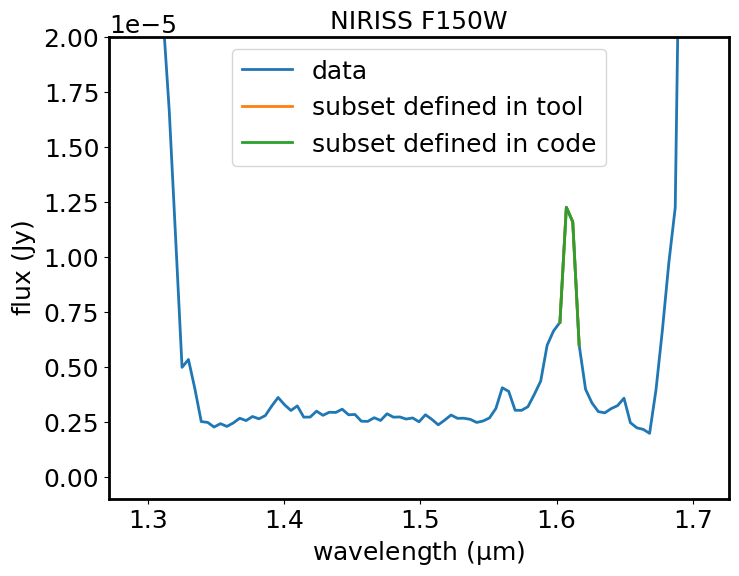

In [13]:
plt.plot(dataout.spectral_axis, dataout.flux, label='data')
plt.plot(spec1d_el_viz.spectral_axis, spec1d_el_viz.flux, label='subset defined in tool')
plt.plot(spec1d_el_code.spectral_axis, spec1d_el_code.flux, label='subset defined in code')
plt.legend()
plt.xlabel("wavelength ({:latex})".format(dataout.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(dataout.flux.unit))
plt.ylim(-1E-6, 2E-5)
plt.title("NIRISS F150W")
plt.show()

## 4. Use the redshift slider in Specviz to find the redshift

I can use available line lists or define my own lines (Here I know I need Hb4862.68 and the [OIII]4960.29,5008.24 doublet) and play with the redshift slider to match the lines in the line list with the lines in the spectrum. The line list plugin can be found clicking the plugin icon on the upper right of the viewer. To input just the three lines, I can use the "Custom" menu.

Here is the documentation where line lists are explained: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#line-lists

I can also define the lines of interest programmatically, as shown in the following cell.

In [14]:
lt = QTable()
lt['linename'] = ['Hb', '[OIII]1', '[OIII]2']
lt['rest'] = [4862.68, 4960.29, 5008.24]*u.AA

viz.load_line_list(lt)

The lines are not showing now because their rest value is outside the range plotted here. I can move the lines using the redshift slider in the line list plugin. It is best to first set the redshift to 2 in the box with the number and then move the slider to bring the lines on top of the observed emission lines.

### Get the redshift out in the Spectrum object

In [15]:
spec1d_redshift = viz.get_spectra(apply_slider_redshift=True)["NIRISS F150W"]
print(spec1d_redshift, '\n')

if spec1d_redshift.redshift != 0.0:
    print("NIRISS F150W redshift=", spec1d_redshift.redshift)
else:
    print("Redshift was not defined in GUI. Defining it here.")
    spec1d_redshift.set_redshift_to(2.2138)
    print("NIRISS F150W redshift=", spec1d_redshift.redshift)

Spectrum (length=114)
Flux=[nan nan nan ... nan nan nan] Jy,  mean=0.00002 Jy
Spectral Axis=[1.76219261 1.75749385 1.7527951  ... 1.24063587 1.23593724
               1.2312386 ] um,  mean=1.49671 um
Uncertainty=StdDevUncertainty ([0. 0. 0. ... 0. 0. 0.] Jy) 

Redshift was not defined in GUI. Defining it here.
NIRISS F150W redshift= 2.2138000000000004


## 5. Model the continuum of the spectrum

I can use the GUI to select the region where I see the continuum. _Challenge_: select a discontinuous subset that covers two intervals (1.35-1.55um and 1.63-1.65um). _Hint_: select "Add" at the top near the Subset dropdown.

I can then use the Model Fitting plugin under the plugin icon to fit a linear model to the selected region. Instructions can be found here: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#model-fitting. The individual steps to complete this task are:
- Select Subset 1 under Data
- Select Linear1D or Polynomial (whatever you think is best) under Model
- Click Add Component
- Enter a name for the model under Output Data Label (I choose "continuum")
- Click "Fit Model"

I can extract the model and its parameters from the datasets in use.

In [16]:
datalabels = viz.data_labels
print(datalabels)
if 'continuum' in datalabels:
    spectrum = viz.get_data('NIRISS F150W')
    continuum = viz.get_data('continuum')
    print(continuum)
else:
    print("Continuum has not been created. Setting it to 0")
    spectrum = viz.get_data('NIRISS F150W')
    continuum = Spectrum(spectral_axis=spectrum.spectral_axis, flux=0.*spectrum.flux)

['NIRISS F150W']
Continuum has not been created. Setting it to 0


I can do a continuum subtraction and plot the result with matplotlib. If the continuum has not been defined in the GUI, this operation returns the original spectrum unchanged.

In [17]:
spectrum_sub = spectrum - continuum

Plot the continuum-subtracted spectrum in blue (flux in Jy versus wavelength in microns). Plot a horizontal black line at a flux level of zero, to help show how well the continuum has been subtracted.

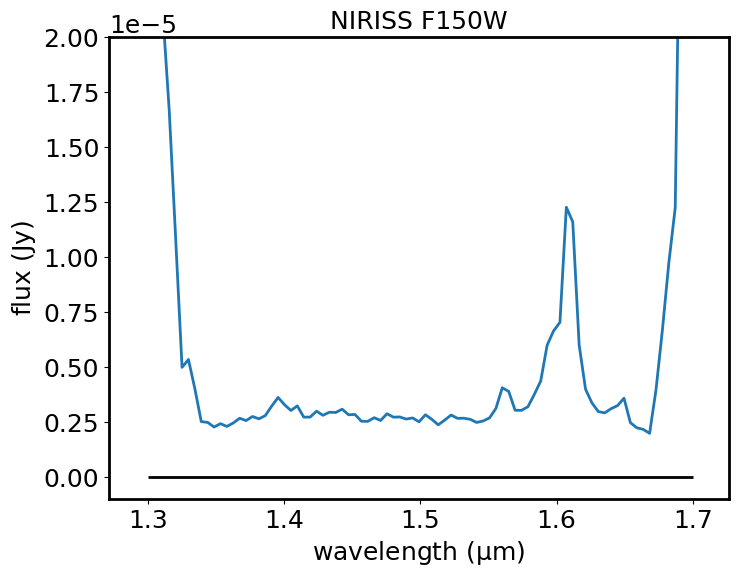

In [18]:
plt.plot(spectrum_sub.spectral_axis, spectrum_sub.flux)
plt.hlines(0, 1.3, 1.7, color='black')
plt.xlabel("wavelength ({:latex})".format(spectrum_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spectrum_sub.flux.unit))
plt.title("NIRISS F150W")
plt.ylim(-1E-6, 2E-5)
plt.show()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>